In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt

import time, datetime

import tfdiffeq
import tensorflow as tf
tf.keras.backend.set_floatx('float64')

# tf.config.list_physical_devices('GPU')

device = 'cpu:0' 

print(f"version: {datetime.datetime.now()}")

version: 2023-06-14 19:18:00.193936


#### load tclab measured data  

model 4.6 consists of 12 cycles and a 360s period of time  
switch with 20s delay, followed by 100s up and 240s down

In [2]:
name = "model.4.6"
fname = os.path.join(os.getcwd(),"data","tclab.%s.csv"%(name))

from _helpers import Helpers_

t,u,y,data_size = Helpers_.tfload_(fname)

print(f"load {name}, size {data_size} items")

load model.4.6, size 4320 items


#### import (neuronal) models and helper

In [3]:
from _models import SurrogateODE, HelperODE, ParamsODE, NeuralPIN

#### neural net training by batch

monitoring data results and loss per iteration with optimizer adam  
batch decision to get a calm loss behaviour

In [4]:
%%time

c_up,c_down = "\u23f6","\u23f7"

def linear_fit_(m,t,y0):
    m_ = m.numpy()
    t_ = t.numpy()
    y0_ = y0.numpy()
    return tf.convert_to_tensor((m_.T*t_).T + y0_)

# iterations to train
n_iters = 5000

batch_time = 10     # time scale to 
batch_due = 0      # due to reduce data size 
                    # to a batch size
batch_size = int((data_size-batch_due)/batch_time)

print_freq = 10     # freq to print sth out

weight_data = 1.
weight_bala = 1.

n_iters_done = n_iters

print(f"iterations {n_iters}")
print(f"batch time {batch_time}, due {batch_due}, size {batch_size}, data {data_size}")

print(f"weight data {weight_data:2.2f}, surrogate {weight_bala:2.2f}")

data_monitor = []
loss_monitor = []

with tf.device(device):

    # build model
    model = NeuralPIN()
    balan = SurrogateODE(params=ParamsODE())

    lr = 1e-3
    optimizer = tf.keras.optimizers.Adam(lr)

    itime = time.time()        

    # iterate
    print(f"iter | {'delay':>10} | {'loss':>15} {'loss(d)':>15} {'loss(b)':>15}")

    for itr in range(1,n_iters+1):
        
        with tf.GradientTape() as tape:

            # batch
            batch_y0, batch_t, batch_u, batch_y, batch_i = HelperODE.batch_(
                t, u, y, 
                batch_size=batch_size, 
                batch_time=batch_time, 
                data_size=data_size)
            
            batch_d = batch_y - batch_y0

            # model: T
            y_pred = model(batch_t,batch_y)

            # surrogate: dTdt
            b_pred = balan(batch_t,batch_y,batch_u)                  
            y_bala = linear_fit_(b_pred, batch_t, batch_y0)
                                              
            # compute loss
            loss_data = tf.multiply(tf.reduce_mean(tf.square(batch_y - y_pred)),weight_data)
            loss_bala = tf.multiply(tf.reduce_mean(tf.square(batch_y - y_bala)),weight_bala)
            
            # early stop
            if loss_data < loss_bala:
                n_iters_done = itr
                print(f"early stop by iteration {n_iters_done} due to {loss_data:12.6} < {loss_bala:12.6}")
                            
            loss = loss_data + loss_bala

            data_monitor.append([
                batch_i,
                y_pred.numpy().flatten(),
                y_bala.numpy().flatten()
                ])
            loss_monitor.append([
                loss.numpy(),
                loss_data.numpy(),
                loss_bala.numpy()
                ])
            
            if itr == n_iters_done:
                break
        
        # pack loss and trainable variables of the tf model
        gg = tape.gradient(loss, model.trainable_variables)
        gv = zip(gg, model.trainable_variables)       
        
        # optimzer setup to do sth against the loss
        optimizer.apply_gradients(gv) 

        if itr % print_freq == 0:            
            
            dt = f"{time.time()-itime:5.2f}"
            
            ls = f"{loss.numpy():12.6f}"
            ld = f"{loss_data.numpy():12.6f}"
            lb = f"{loss_bala.numpy():12.6f}"

            ds = c_down if loss.numpy() < loss_monitor[itr-print_freq-1][0] else c_up
            dd = c_down if loss_data.numpy() < loss_monitor[itr-print_freq-1][1] else c_up
            db = c_down if loss_bala.numpy() < loss_monitor[itr-print_freq-1][2] else c_up
            
            print(f"{itr:04d} | {dt:>10} | {ls:>15}{ds}{ld:>15}{dd}{lb:>15}{db}")
            itime = time.time()


iterations 5000
batch time 10, due 0, size 432, data 4320
weight data 1.00, surrogate 1.00
iter |      delay |            loss         loss(d)         loss(b)
0010 |       0.58 |      974.536756⏶     973.489092⏶       1.047664⏶
0020 |       0.37 |      881.503059⏷     880.192333⏷       1.310726⏶
0030 |       0.35 |      911.407779⏶     910.324663⏶       1.083116⏷
0040 |       0.34 |      834.488034⏷     833.356928⏷       1.131106⏶
0050 |       0.33 |      833.783189⏷     832.698624⏷       1.084565⏷
0060 |       0.34 |      836.662249⏶     835.631448⏶       1.030801⏷
0070 |       0.33 |      764.166671⏷     763.071892⏷       1.094778⏶
0080 |       0.33 |      782.928783⏶     781.978095⏶       0.950688⏷
0090 |       0.33 |      748.266527⏷     747.091471⏷       1.175057⏶
0100 |       0.33 |      707.476442⏷     706.490780⏷       0.985662⏷
0110 |       0.33 |      634.357617⏷     633.182881⏷       1.174737⏶
0120 |       0.34 |      651.061075⏶     649.985049⏶       1.076026⏷
0130 |       

#### save model of the neural ode model

In [5]:
model_name = os.path.join(os.getcwd(),"data","tclab.%s.pinn.tf"%(name))
model.save(model_name, save_format="tf")

INFO:tensorflow:Assets written to: c:\Develop\vsc\tclab\data\tclab.model.4.6.pinn.tf\assets


#### plot results over data set and loss

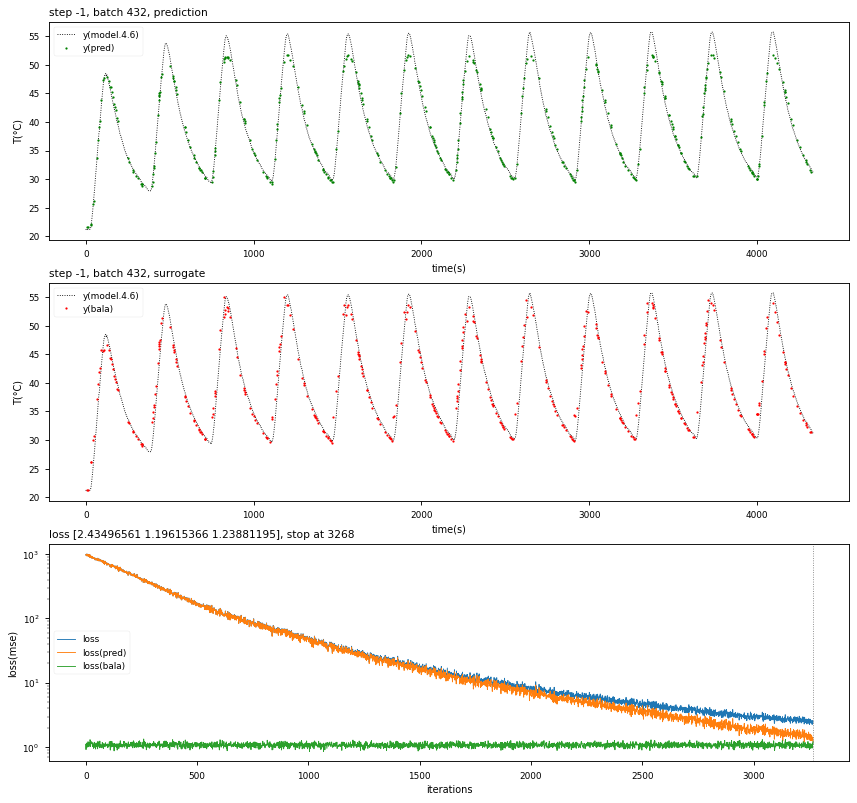

In [6]:
def plot_(data_monitor, loss_monitor, batch_size, step_number=-1, n_iters = 0):

    marker_size = 2

    plt.rcParams["font.size"] = 8
    plt.rcParams["figure.dpi"] = 80
    plt.rcParams["lines.linewidth"] = .8

    ncols,nrows = 1,3
    nwidth,nheight = 16,4

    fig, axx = plt.subplots(nrows=nrows,ncols=ncols,figsize=[nwidth*ncols,nheight*nrows],dpi=plt.rcParams["figure.dpi"])
    fig.subplots_adjust(right=0.75)

    ts = t.numpy().flatten()
    ys = y.numpy().flatten()

    k = step_number   

    # time by batched indizes
    i_ = data_monitor[k][0]
    t_ = ts[i_]

    # batch slices in one chain   

    # -------------------

    ax = axx[0]

    ax.plot(ts,ys,":",color="black",label="y(%s)"%(name))

    s_ = data_monitor[k][1]

    batch_number = 1
    y_ = s_[-batch_number*batch_size:len(s_)-(batch_number-1)*batch_size]
    ax.plot(t_,y_,'o',ms=marker_size,label="y(pred)",color="green")

    ax.set_xlabel("time(s)"); ax.set_ylabel("T(°C)")
    ax.legend()
    ax.set_title(f"step {step_number}, batch {batch_size}, prediction",x=0,ha="left")

    # -------------------

    ax = axx[1]

    ax.plot(ts,ys,":",color="black",label="y(%s)"%(name))

    s_ = data_monitor[k][2]
    y_ = s_[-batch_number*batch_size:len(s_)-(batch_number-1)*batch_size]
    ax.plot(t_,y_,'o',ms=marker_size,label="y(bala)",color="red")

    ax.set_xlabel("time(s)"); ax.set_ylabel("T(°C)")
    ax.legend()
    ax.set_title(f"step {step_number}, batch {batch_size}, surrogate",x=0,ha="left")

    # -------------------

    ax = axx[-1]

    lm = np.array(loss_monitor)
    for i in range(lm.shape[1]):
        ax.plot(lm[:,i],label=f"{['loss','loss(pred)','loss(bala)'][i]}")
    ax.set_yscale("log")
    ax.legend()
    ax.set_xlabel("iterations"); ax.set_ylabel("loss(mse)")

    ax.axvline(x=lm.shape[0]+step_number,color="grey",linestyle=":")
    
    ax.set_title(f"loss {lm[-1,:]}, stop at {n_iters}",x=0,ha="left")

    plt.show()
    plt.close()


plot_(data_monitor, loss_monitor, batch_size, step_number=-1, n_iters=n_iters_done)


#### plot surrogate and neural ode test results

the higher the batch due, the smaller the batch and the loss increases  
surrogate cannot make a better evaluation  
for test purposes only that the model is reconstructed correctly and to compare the surrogate  

In [7]:

def plot_test(ts,us,ys,
              yy,
              loss,
              indizes,
              size,
              name
              ):
    
    marker_size = 1

    plt.rcParams["font.size"] = 8
    plt.rcParams["figure.dpi"] = 100
    plt.rcParams["lines.linewidth"] = .8

    ncols,nrows = 1,2
    nwidth,nheight = 16,4

    fig, axx = plt.subplots(nrows=nrows,ncols=ncols,figsize=[nwidth*ncols,nheight*nrows],dpi=plt.rcParams["figure.dpi"])
    fig.subplots_adjust(right=0.75)

    # model test

    ax = axx[0]

    ax.plot(ts,ys,":",color="grey",label="y(%s)"%(name))

    i_ = indizes
    a_ = np.argsort(i_)
    t_ = ts[i_[a_]]
    y_ = yy[0][-size:][a_]

    ax.plot(t_,y_,':o',ms=marker_size,label="y(test)",color="green")

    ax.legend()
    ax.set_title("test with batch %d, loss %.6f"%(size, loss[0]),x=0,ha="left")

    ax = ax.twinx()
    ax.plot(ts,us,":",label="u",color="gray")

    # balance equivalence

    ax = axx[1]

    ax.plot(ts,ys,":",color="grey",label="y(%s)"%(name))

    i_ = indizes
    a_ = np.argsort(i_)
    t_ = ts[i_[a_]]
    y_ = yy[1][-size:][a_]

    ax.plot(t_,y_,':o',ms=marker_size,label="y(surr)",color="red")

    ax.legend()
    ax.set_title("surrogate with batch %d, loss %.6f"%(size,loss[1]),x=0,ha="left")

    ax = ax.twinx()
    ax.plot(ts,us,":",label="u",color="gray")

    for ax in axx.ravel():
        ax.set_xlabel("time(s)")
        ax.set_ylabel("T(°C)")

    plt.show()
    plt.close()


#### load data of model.q.X  

test for convenience  
model contains random generated switching states

In [8]:
name2 = "model.q.3"
fname2 = os.path.join(os.getcwd(),"data","tclab.%s.csv"%(name2))

t2,u2,y2,data_size2 = Helpers_.tfload_(fname2)

print(f"load {name2}, size {data_size2}")

load model.q.3, size 1200


In [9]:
%%time

batch_time_test2 = 2
batch_due_test2 = 0
batch_size_test2 = int((data_size2 - batch_due_test2)/batch_time_test2)

with tf.device(device):
    
    # reconstruct the trained neural ode
    model_name = os.path.join(os.getcwd(),"data","tclab.model.4.6.pinn.tf")
    recon = tf.keras.models.load_model(model_name, compile=False)
    
    batch_y02, batch_t2, batch_u2, batch_y2,batch_i2 = HelperODE.batch_(
        t2, u2, y2, 
        batch_size=batch_size_test2, 
        batch_time=batch_time_test2, 
        data_size=data_size2)
    
    # model
    y_test2 = model(batch_t2,batch_y2)

    l_test2 = tf.reduce_mean(tf.square(batch_y2 - y_test2))

    # surrogate
    params = ParamsODE()
    params.alpha = 0.
    balan = SurrogateODE(params=params)
    # surrogate: dTdt
    b_pred2 = balan(batch_t2,batch_y2,batch_u2)    
    
    # linear results to predict balance
    y_ = b_pred2.numpy()
    t_ = batch_t2.numpy()
    y0_ = batch_y02.numpy()
    #y_bala2 = tf.convert_to_tensor((y_.T*t_).T + y0_)

    y_bala2 = linear_fit_(b_pred2,batch_t2,batch_y02)

    l_bala2 = tf.reduce_mean(tf.square(batch_y2 - y_bala2))

    y_test2 = y_test2.numpy().flatten()
    y_bala2 = y_bala2.numpy().flatten()

print(f"data size {data_size2}; batch time {batch_time_test2} due {batch_due_test2} size {batch_size_test2}")
print(f"loss test {l_test2:.6f} and surrogate {l_bala2:.6f}")

data size 1200; batch time 2 due 0 size 600
loss test 0.099943 and surrogate 0.011962
CPU times: total: 125 ms
Wall time: 377 ms


#### plot q-test model result and surrogate test result  

surrogate is not as good as expected  
neural ode knows more about the instrinsic properties  

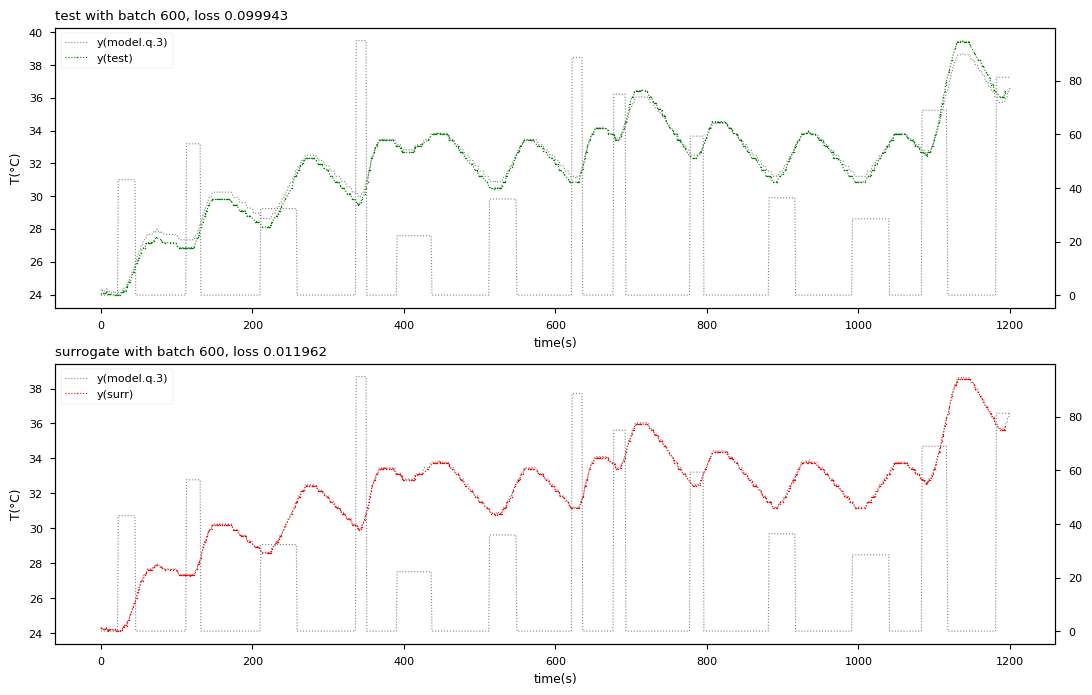

In [10]:
ts = t2.numpy().flatten()
us = u2.numpy().flatten()
ys = y2.numpy().flatten()

plot_test(ts,us,ys,
          yy=[y_test2,y_bala2],
          loss=[l_test2,l_bala2],
          indizes=batch_i2,
          size=batch_size_test2,
          name=name2
          )